In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from datetime import datetime as dt
import numpy as np
from scipy.stats.stats import pearsonr  
from sklearn.preprocessing import normalize

plt.style.use('ggplot')
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("data/churn_dataset.csv")

In [3]:
df.shape

(38822, 75)

In [4]:
df.head().T

,0,1,2,3,4
customer_db_id,54478736d4cde82247f1345f,54478fa4d3cde8d17ca5e4db,5447eefcd3cde8cf7ca5e4eb,5447f1a2d4cde82147f1347d,544976fad4cde8f3415bedb0
customer_id,GB-CUS-Y8922200,GB-CUS-K3854440,GB-CUS-L2277081,GB-CUS-C3589820,GB-CUS-P7798401
gender,male,female,male,male,male
segment,NaN,RED,NaN,NaN,NaN
aov,NaN,10.1501,NaN,NaN,NaN
recency,1370,1211,1370,1370,1190
frequency,0,0,0,0,0
churn_factor,1,1,1,1,1
referred,False,False,False,False,False
newsletter_optin,False,False,False,False,False


# Preprocessing

In [5]:
df['churned'] = [True if x > 1 else False for x in df.churn_factor]
df['first_order_voucher_revenue_ratio'] = df.first_order_voucher_value / (df.first_order_voucher_value + df.first_order_revenue)

## Fill NAs

In [6]:
nans = df.isnull().sum()
nans[nans > 0].sort_values(ascending = False)

refunds_unsuccess                    38801
refunds_success                      38179
rating_diff                          32774
last_order_rating                    32774
first_order_rating                   30620
first_order_fac_name                 26065
avg_rating                           25465
last_order_voucher_channel           23218
last_order_fac_name                  20815
first_order_voucher_channel          20005
first_order_products                 10820
first_order_voucher_revenue_ratio     7315
first_order_voucher_value             7314
last_order_voucher_value              6360
last_order_hub_distance               5837
first_order_hub_distance              5779
avg_hub_distance                      4720
aov                                   4115
segment                               4115
gender                                1140
zip_area                               613
zip                                    498
dtype: int64

In [7]:
df['first_order_products'] = df['first_order_products'].fillna("")

In [8]:
df[['refunds_unsuccess', 'refunds_success']] = df[['refunds_unsuccess', 'refunds_success']].fillna(0)

In [9]:
rating_cols = ['avg_rating', 'rating_diff', 'last_order_rating', 'rated_orders', 'first_order_rating']
df[rating_cols] = df[rating_cols].fillna(-999)
df.loc[df.rated_orders > 0, rating_cols].head()

,avg_rating,rating_diff,last_order_rating,rated_orders,first_order_rating
31,5.000000,-999.000000,-999.0,1,-999.0
33,4.821429,-999.000000,-999.0,28,-999.0
38,4.897436,-999.000000,-999.0,39,-999.0
44,3.888889,-999.000000,-999.0,9,-999.0
46,2.333333,2.666667,5.0,3,-999.0


In [10]:
df.aov = df.aov.fillna(0)
df.segment = df.segment.fillna('None')
df.gender = df.gender.fillna('Unknown')

In [11]:
df.zip = df.zip.fillna('Unknown')
df.zip_area = df.zip_area.fillna('Unknown')

df.avg_hub_distance = df.avg_hub_distance.fillna(-999)
df.last_order_hub_distance = df.last_order_hub_distance.fillna(-999)
df.first_order_hub_distance = df.first_order_hub_distance.fillna(-999)

In [12]:
df.first_order_date = pd.to_datetime(df.first_order_date)
df['first_order_week'] = df['first_order_date'].dt.week
df['first_order_year'] = df['first_order_date'].dt.year
df['first_order_day'] = df['first_order_date'].dt.day
df['first_order_month'] = df['first_order_date'].dt.month

In [13]:
df.first_order_fac_name = df.first_order_fac_name.fillna('unknown')
df.first_order_voucher_channel = df.first_order_voucher_channel.fillna('unknown')
df.first_order_voucher_value = df.first_order_voucher_value.fillna(-999)
df.first_order_voucher_revenue_ratio = df.first_order_voucher_revenue_ratio.fillna(0)
df.last_order_fac_name = df.last_order_fac_name.fillna('unknown')
df.last_order_voucher_channel = df.last_order_voucher_channel.fillna('unknown')
df.last_order_voucher_value = df.last_order_voucher_value.fillna(-999)

In [14]:
nans = df.isnull().sum()
nans[nans > 0].sort_values(ascending = False)

Series([], dtype: int64)

## Label Encoding

In [15]:
voucher_channel_le = LabelEncoder()
voucher_channel_le.fit(df.first_order_voucher_channel)
df['first_order_voucher_channel_enc'] = voucher_channel_le.transform(df.first_order_voucher_channel.tolist())

products_le = LabelEncoder()
products_le.fit(df.first_order_products)
df['first_order_products_enc'] = products_le.transform(df.first_order_products.tolist())

facility_le = LabelEncoder()
facility_le.fit(df.first_order_fac_name)
df['first_order_fac_name_enc'] = facility_le.transform(df.first_order_fac_name.tolist())

order_date_le = LabelEncoder()
order_date_le.fit(df.first_order_date.sort_values().dt.strftime('%Y-%m-%d'))
df['first_order_date_enc'] = order_date_le.transform(df.first_order_date.dt.strftime('%Y-%m-%d').tolist())

# All customers analysis

In [16]:
df.head()

,customer_db_id,customer_id,gender,segment,aov,recency,frequency,churn_factor,referred,newsletter_optin,...,churned,first_order_voucher_revenue_ratio,first_order_week,first_order_year,first_order_day,first_order_month,first_order_voucher_channel_enc,first_order_products_enc,first_order_fac_name_enc,first_order_date_enc
0,54478736d4cde82247f1345f,GB-CUS-Y8922200,male,None,0.000000,1370,0.0,1.0,False,False,...,False,0.0,43,2014,22,10,24,0,21,0
1,54478fa4d3cde8d17ca5e4db,GB-CUS-K3854440,female,RED,10.150078,1211,0.0,1.0,False,False,...,False,0.0,43,2014,22,10,24,8,21,0
2,5447eefcd3cde8cf7ca5e4eb,GB-CUS-L2277081,male,None,0.000000,1370,0.0,1.0,False,False,...,False,0.0,43,2014,22,10,24,0,21,0
3,5447f1a2d4cde82147f1347d,GB-CUS-C3589820,male,None,0.000000,1370,0.0,1.0,False,False,...,False,0.0,43,2014,22,10,24,0,21,0
4,544976fad4cde8f3415bedb0,GB-CUS-P7798401,male,None,0.000000,1190,0.0,1.0,False,False,...,False,0.0,7,2015,10,2,24,0,21,104


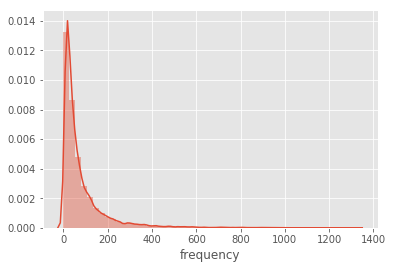

In [17]:
sns.distplot(df.loc[df.valid_orders > 1].frequency)

In [18]:
zips = df.groupby(['zip'])['customer_db_id'].nunique().sort_values(ascending=False)
zips = zips.loc[zips > 20].reset_index().zip.unique()

df_seg = df.loc[df.zip.isin(zips)].groupby(['segment', 'zip_area', 'zip'])\
                    ['customer_db_id'].nunique()\
                    .reset_index()\
                    .rename(columns={'customer_db_id': 'customers'})
df_seg = df_seg.merge(df_seg.groupby(['segment'])\
                      ['customers'].sum()\
                      .reset_index()\
                      .rename(columns={'customers': 'segment_total'}), on='segment')
df_seg['customers_segment'] = df_seg.customers / df_seg.segment_total

In [19]:
# flatui = ["BLACK", "YELLOW", "RED", "GREEN", "GREEN", "GRAY"]
# sns.set_palette(flatui)

# # zip_areas = df_seg.zip_area.unique().tolist()
# # fig, axarray = plt.subplots(nrows=len(zip_areas), figsize=(10,10))

# # for idx, zip_area in enumerate(zip_areas):
    
# #     ax = axarray[idx]
# #     sns.barplot(data=df_seg.loc[df_seg.zip_area == zip_area], x='zip', y='customers_segment', hue='segment', 
# #                 hue_order=['BLACK', 'GOLD', 'RED', 'GREEN.PROFIT', 'GREEN.DENSITY', 'None'], ax=ax)
# #     ax.legend_.remove()
# # plt.tight_layout()

# zip_areas = df_seg.zip_area.unique().tolist()
# fig, axarr = plt.subplots(nrows=len(zip_areas), figsize=(8,25))

# for idx, zip_area in enumerate(zip_areas):
#     ax = axarr[idx]
#     sns.barplot(data=df_seg.loc[df_seg.zip_area == zip_area], x='zip', y='customers_segment', hue='segment', 
#                 hue_order=['BLACK', 'GOLD', 'RED', 'GREEN.PROFIT', 'GREEN.DENSITY', 'None'], ax=ax)
#     ax.legend_.remove()
# plt.tight_layout()

# sns.set()

# Bad vs Good Voucher Customers
*Assumption: Bad customers are customers who had one completed order using a voucher, had a good customer experience and didn't place another order for more than a year. These customers should be excluded from churn analysis.*

We want to analyse, if there are any specific features, such as area, channels, products that identify bad customers. In order to analyse, we create a 'Good Customers' group, which are customers, who have returned after their first order with vouchers.

Bad Voucher customers: 
- First_Order_Voucher == TRUE
- Completed_Orders == 1
- Total_Orders == 1
- Last_Order > 365 days ago

Good Voucher customers:
- First_Order_Voucher == TRUE
- Completed_Orders > 1

In [20]:
df_vou = df.loc[df.first_order_voucher & df.valid_orders > 0]
df_vou_good = df_vou.loc[(df_vou.valid_orders > 1)]
df_vou_bad = df_vou.loc[(df_vou.valid_orders == 1) & (df_vou.total_orders == 1) & (df_vou.recency > 365)]

df_vou_bad = df_vou_bad.loc[df_vou_bad.first_order_date < "2017-07-21"]
df_vou_good = df_vou_good.loc[df_vou_good.first_order_date < "2017-07-21"]

In [21]:
print('Number of Bad customers: ', df_vou_bad.shape[0])
print('Number of Good customers: ', df_vou_good.shape[0])

df_vou_bad['customer_type'] = 'bad'
df_vou_good['customer_type'] = 'good'

Number of Bad customers:  6873
Number of Good customers:  2281


In [22]:
def plot_bad_vs_good_by_column(column_name):
    df_bad = df_vou_bad.groupby(column_name)['customer_db_id'].nunique() / df_vou_bad.shape[0]
    df_good = df_vou_good.groupby(column_name)['customer_db_id'].nunique() / df_vou_good.shape[0]
    df_diff = df_good - df_bad
    df_diff_relative = df_diff / (df_bad + df_good)
    df = pd.concat([df_bad, df_good, df_diff, df_diff_relative], 
                  axis=1, keys=['bad', 'good', 'diff', 'diff_relative'], sort=True)
    
    df = df.sort_values('diff', ascending=False)
    df[['bad', 'good']].plot(kind='bar', title=column_name)
    df[['diff']].plot(kind='bar', title='diff (+ more good / - more bad)', color='orange')
#     df[['diff_relative']].sort_values('diff_relative', ascending=False).plot(kind='bar', title='diff relative (diff / all customers)', color='orange')

# Bad customers with Bad experience
*Assumption: If a BAD customer churned because of bad experience, he should be included in the churn analysis*

Customers falling into the following groups should not be excluded from analysis:
* reclean_order
* order_rating < 4
* internal_reschedules > 1
* refund

In [23]:
df_vou_bad.groupby(['reclean_orders'])['customer_db_id'].nunique()

reclean_orders
0    6861
1      12
Name: customer_db_id, dtype: int64

In [24]:
df_vou_bad.groupby(['last_order_rating'])['customer_db_id'].nunique()

last_order_rating
-999.0    5704
 1.0       101
 2.0        37
 3.0       106
 4.0       247
 5.0       678
Name: customer_db_id, dtype: int64

In [25]:
df_vou_bad.groupby(['internal_reschedules'])['customer_db_id'].nunique()

internal_reschedules
0    6546
1     249
2      56
3      18
4       3
5       1
Name: customer_db_id, dtype: int64

In [26]:
df_vou_bad.groupby(['refunds_success'])['customer_db_id'].nunique()

refunds_success
0.0    6865
1.0       8
Name: customer_db_id, dtype: int64

In [27]:
df_vou_bad_exp = df_vou_bad.loc[
    (df_vou_bad.reclean_orders == 1) |
    (df_vou_bad.last_order_rating < 4) |
    (df_vou_bad.refunds_success == 1) |
    (df_vou_bad.internal_reschedules > 1)
]

df_vou_bad = df_vou_bad.loc[~df_vou_bad.customer_db_id.isin(df_vou_bad_exp.customer_db_id)]
df_both = pd.concat([df_vou_bad, df_vou_good])
df_both['customer_type_enc'] = df_both['customer_type'].map({'bad': -1, 'good': 1})

print('Bad with bad experience: ', df_vou_bad_exp.shape[0])
print('Bad with good experience: ', df_vou_bad.shape[0])

Bad with bad experience:  5958
Bad with good experience:  915


# Bad Customers with Good Experience

## Voucher Channel
*Assumption: The channel through which the customer has received the voucher influences if the acquired customer is going to come back after the first order.*

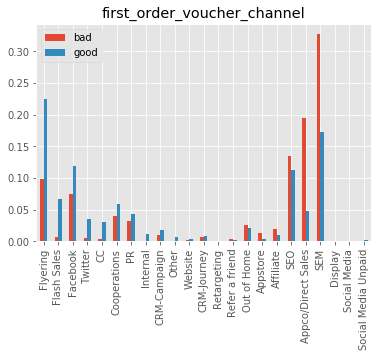

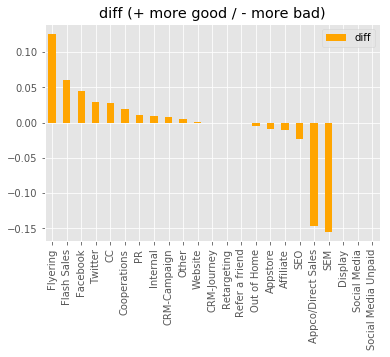

In [28]:
plot_bad_vs_good_by_column('first_order_voucher_channel')

Conclusion: Customers that have acquired their vouchers from the following channels are **likely to churn after first order, even if they had a good customer experience**, and should be excluded from the analysis.
* SEO
* SEM
* Appco/Direct Sales



In [29]:
bad_voucher_channels = ['SEO', 'SEM', 'Appco/Direct Sales']

## Voucher Value

customer_type                           bad         good
first_order_voucher_value count  915.000000  2126.000000
                          mean    16.140532    17.294447
                          std      5.991715    10.260622
                          min      1.205250     0.000000
                          25%     11.864800    12.688902
                          50%     17.361428    13.920107
                          75%     18.986536    19.167794
                          max     77.002658   128.244158

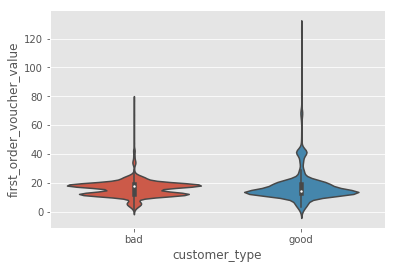

In [30]:
a = df_both.loc[df_both.first_order_voucher_value != -999, ['customer_type', 'first_order_voucher_value']]
sns.categorical.violinplot(data=a, x='customer_type', y='first_order_voucher_value')

a.groupby('customer_type').describe().T

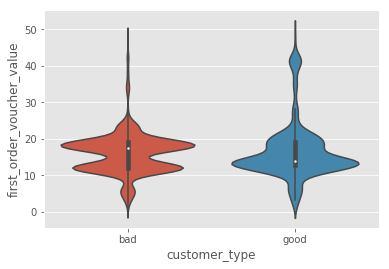

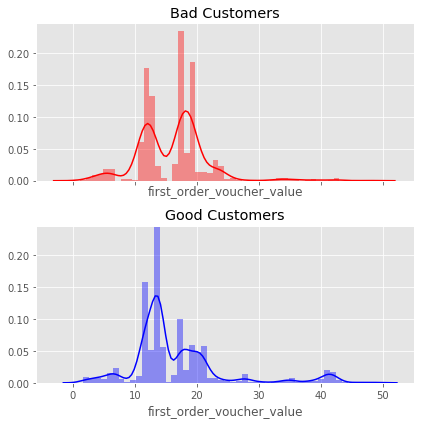

In [31]:
a = df_both.loc[(df_both.first_order_voucher_value > 0) &
                (df_both.first_order_voucher_value < 50), 
                ['customer_type', 'first_order_voucher_value']]
sns.categorical.violinplot(data=a, x='customer_type', y='first_order_voucher_value')

f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True,figsize=(6,6))
sns.distplot(a.loc[a.customer_type == 'bad', 'first_order_voucher_value'], ax=ax1, color='red', bins=50)
ax1.set_title('Bad Customers')
sns.distplot(a.loc[a.customer_type == 'good', 'first_order_voucher_value'], ax=ax2, color='blue', bins=50)
ax2.set_title('Good Customers')
plt.tight_layout()

customer_type                                   bad         good
first_order_voucher_revenue_ratio count  915.000000  2281.000000
                                  mean     0.638716     0.509412
                                  std      0.263462     0.298304
                                  min      0.048195     0.000000
                                  25%      0.436443     0.263794
                                  50%      0.642857     0.494030
                                  75%      0.878477     0.705882
                                  max      1.000000     1.000000

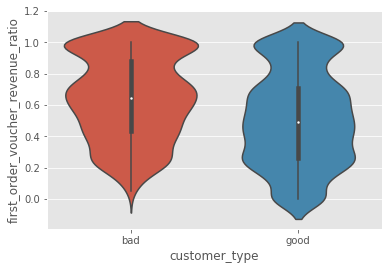

In [32]:
a = df_both.loc[df_both.first_order_voucher_revenue_ratio != np.inf, ['customer_type', 'first_order_voucher_revenue_ratio']]
sns.categorical.violinplot(data=a, x='customer_type', y='first_order_voucher_revenue_ratio')

a.groupby('customer_type').describe().T

## Distance to Hub
*Assumption: The distance of the customer to the hub influences the availability he/she sees when they place an order. If there is bad availability, the customer might not come back.*

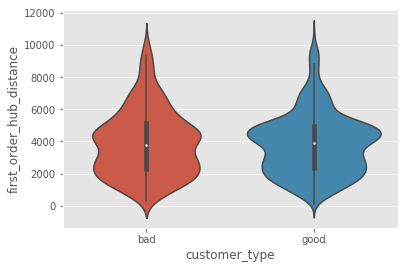

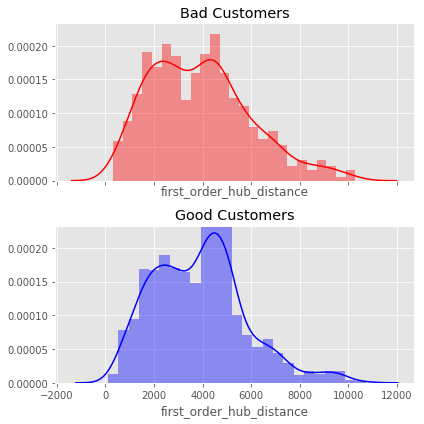

In [33]:
a = df_both.loc[df_both.first_order_hub_distance != -999, ['customer_type', 'first_order_hub_distance']]
sns.categorical.violinplot(data=a, x='customer_type', y='first_order_hub_distance')

f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True,figsize=(6,6))
sns.distplot(a.loc[a.customer_type == 'bad', 'first_order_hub_distance'], ax=ax1, color='red', bins=25)
ax1.set_title('Bad Customers')
sns.distplot(a.loc[a.customer_type == 'good', 'first_order_hub_distance'], ax=ax2, color='blue', bins=25)
ax2.set_title('Good Customers')
plt.tight_layout()

*Conclusion*: It doesn't seem that distance to hub plays a role in the first_voucher_order churn.

## First Order Revenue
*Assumption: Depending on how much the customer actually spent on their first voucher order, determines if they are going to order again or not. Customer who spend more, tend to be good customers, because they can afford our service regularly*

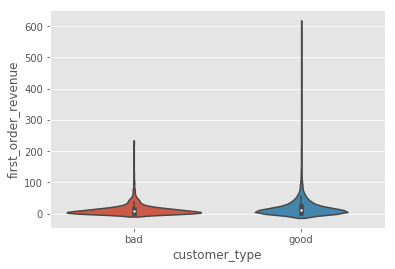

In [34]:
a = df_both[['customer_type', 'first_order_revenue']]
sns.categorical.violinplot(data=a, x='customer_type', y='first_order_revenue')

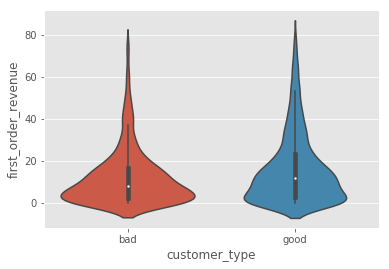

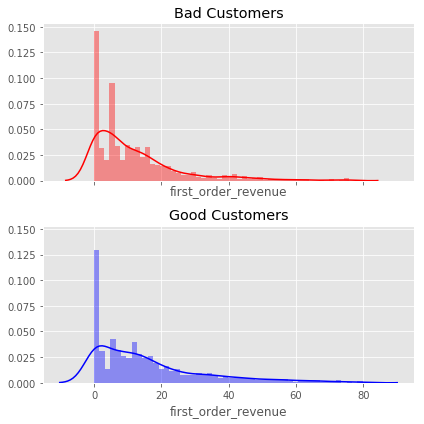

In [35]:
a = df_both.loc[df_both.first_order_revenue < 80, ['customer_type', 'first_order_revenue']]
sns.categorical.violinplot(data=a, x='customer_type', y='first_order_revenue')

f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True,figsize=(6,6))
sns.distplot(a.loc[a.customer_type == 'bad', 'first_order_revenue'], ax=ax1, color='red', bins=50)
ax1.set_title('Bad Customers')
sns.distplot(a.loc[a.customer_type == 'good', 'first_order_revenue'], ax=ax2, color='blue', bins=50)
ax2.set_title('Good Customers')
plt.tight_layout()

## Dates
*Assumption: The dates when more bad customers came than good, could mean that there was a certain period of campaigns that attracted undesirable customers.*

In [36]:
bad_limit = df_vou_bad.loc[df_vou_bad.first_order_date < "2017-07-21"]
good_limit = df_vou_good.loc[df_vou_good.first_order_date < "2017-07-21"]
bad = bad_limit\
        .groupby('first_order_date')['customer_db_id']\
        .nunique() / bad_limit.shape[0]
good = good_limit\
        .groupby('first_order_date')['customer_db_id']\
        .nunique() / good_limit.shape[0]

df_plot = pd.concat([bad, good], axis=1, keys=['bad', 'good']).reset_index()
df_plot = df_plot.groupby([pd.Grouper(key='first_order_date', freq='MS')])[['bad', 'good']]\
        .sum()\
        .reset_index()\
        .sort_values('first_order_date')\
        .set_index('first_order_date')

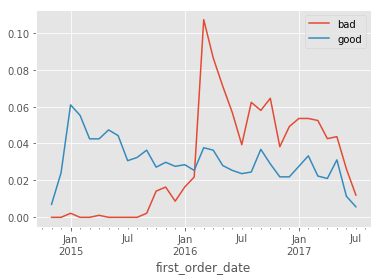

In [37]:
df_plot.plot()

*Conclusion*: Seems that there were some areas, especially around Feb - April 2016, where loads of "bad customers" were coming in. We should look at what kind of campaigns there were running at that time.

## Facility
*Assumption: Some facilities provide better services and therefore customers who churned after first order, although having a 'good' facility, are concidered bad.*

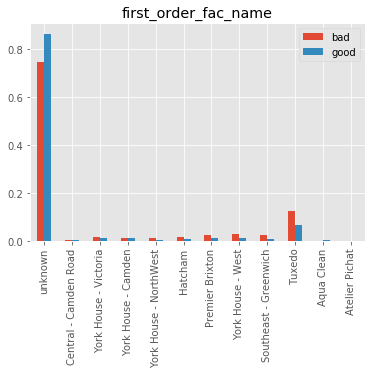

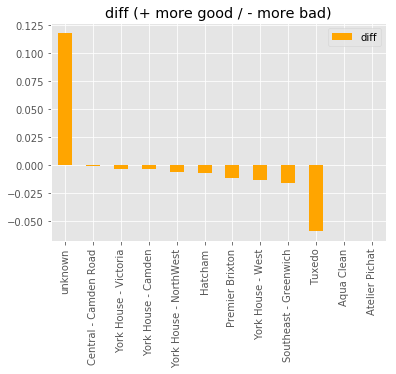

In [38]:
plot_bad_vs_good_by_column('first_order_fac_name')

## Product Segmentation
*Assumption: Bad customers order certain type of products*

TODO: too many UNKNOWN values for bad customers, need to include itemization

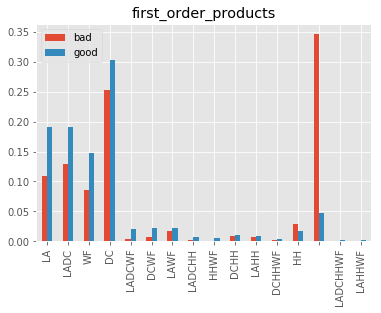

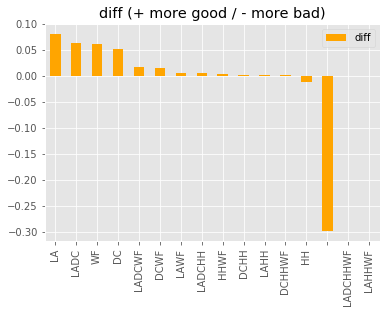

In [39]:
plot_bad_vs_good_by_column('first_order_products')

## Service Class

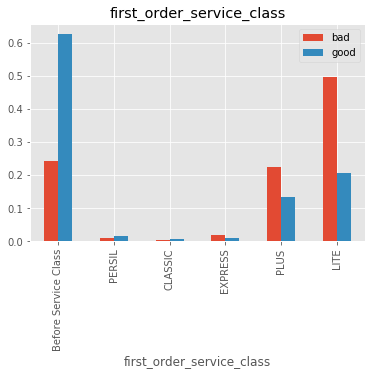

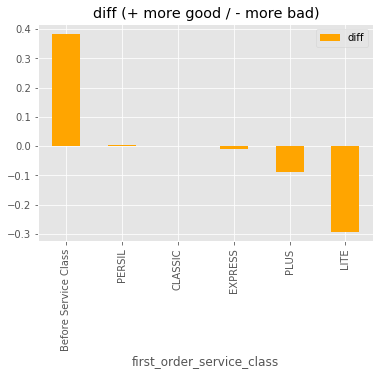

In [40]:
plot_bad_vs_good_by_column('first_order_service_class')

## Gender

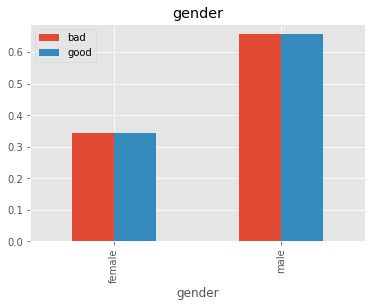

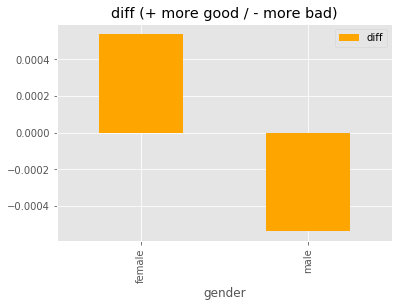

In [41]:
plot_bad_vs_good_by_column('gender')

## Zip Area

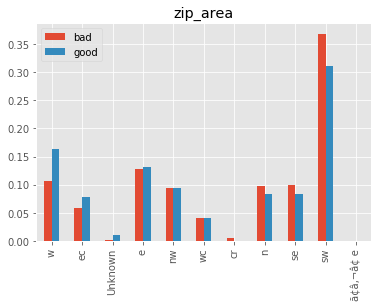

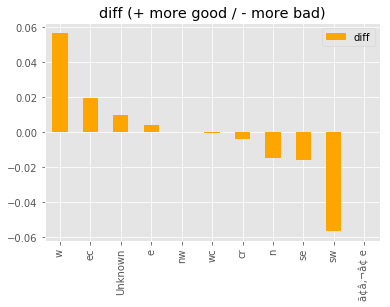

In [42]:
plot_bad_vs_good_by_column('zip_area')

# Correlations

In [43]:
df_both.columns

Index(['customer_db_id', 'customer_id', 'gender', 'segment', 'aov', 'recency',
       'frequency', 'churn_factor', 'referred', 'newsletter_optin', 'city',
       'valid_orders', 'open_orders', 'canceled_orders', 'pay_error_orders',
       'completed_orders', 'total_orders', 'last_order_state',
       'last_order_date', 'first_order_date', 'Before Service Class',
       'CLASSIC', 'EXPRESS', 'LITE', 'PERSIL', 'PLUS',
       'last_order_service_class', 'first_order_service_class', 'product_LA',
       'product_HH', 'product_DC', 'product_WF', 'first_order_products',
       'vouchers_used', 'vouchers_revenue_ratio',
       'first_order_voucher_channel', 'first_order_voucher_value',
       'last_order_voucher_channel', 'last_order_voucher_value',
       'first_order_voucher', 'last_order_voucher', 'first_order_revenue',
       'last_order_revenue', 'reclean_orders', 'last_reclean_order',
       'reclean_ratio', 'internal_reschedules', 'customer_reschedules',
       'rated_orders', 'avg_rat

In [44]:
df_good = df_vou_good.loc[df_vou_good.first_order_voucher_value != -999].sample(df_vou_bad.shape[0])
df_bad = df_vou_bad.copy()
df_sample = pd.concat([df_good, df_bad])
df_sample['customer_type_enc'] = df_sample['customer_type'].map({'bad': -1, 'good': 1})

print('Bad: {}, Good: {}'.format(df_bad.shape[0], df_good.shape[0]))

Bad: 915, Good: 915


In [45]:
features = ['customer_type_enc', 'first_order_products_enc', 'first_order_voucher_channel_enc', 
            'first_order_voucher_value', 'first_order_revenue',             'first_order_voucher_revenue_ratio']
df_plot = df_sample[features]

In [46]:
df_plot.corr()

,customer_type_enc,first_order_products_enc,first_order_voucher_channel_enc,first_order_voucher_value,first_order_revenue,first_order_voucher_revenue_ratio
customer_type_enc,1.000000,0.243809,0.001781,0.093191,0.174096,-0.166790
first_order_products_enc,0.243809,1.000000,-0.002592,-0.031871,-0.011829,-0.015767
first_order_voucher_channel_enc,0.001781,-0.002592,1.000000,-0.078562,0.053740,-0.117068
first_order_voucher_value,0.093191,-0.031871,-0.078562,1.000000,0.072471,0.400769
first_order_revenue,0.174096,-0.011829,0.053740,0.072471,1.000000,-0.666306
first_order_voucher_revenue_ratio,-0.166790,-0.015767,-0.117068,0.400769,-0.666306,1.000000


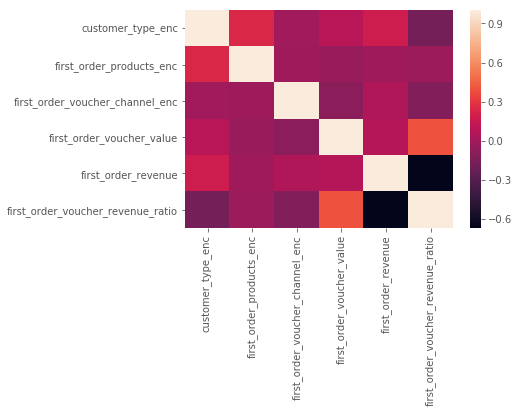

In [47]:
sns.heatmap(df_plot.corr(), 
            xticklabels=df_plot.corr().columns.values,
            yticklabels=df_plot.corr().columns.values)

In [48]:
X = df_plot[df_plot.columns.tolist()[1:]].values
y = df_plot['customer_type_enc'].values

In [49]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
neigh = DecisionTreeClassifier()
neigh.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [50]:
neigh.feature_importances_

array([0.212102  , 0.16954518, 0.36638587, 0.16276328, 0.08920366])

In [51]:
pd.DataFrame(index=df_plot.columns.tolist()[1:], data=neigh.feature_importances_)

,0
first_order_products_enc,0.212102
first_order_voucher_channel_enc,0.169545
first_order_voucher_value,0.366386
first_order_revenue,0.162763
first_order_voucher_revenue_ratio,0.089204


In [57]:
import graphviz 

dot_data = tree.export_graphviz(neigh, out_file=None, 
                         feature_names=df_plot.columns.tolist()[1:],  
                         class_names=df_plot.customer_type_enc.astype(str).tolist(),  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH